In [0]:
#Unfortunately, the default version for tensorflow on colab is 2.0 now
#We stick to 1.x for this one
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
#helper
import tensorflow as tf


def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


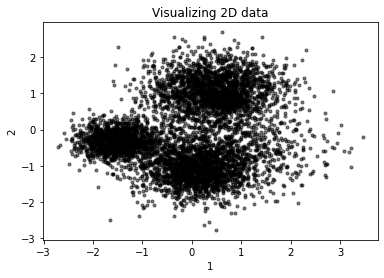

In [0]:
#kmeans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Loading data
#data = np.load('data2D.npy')
data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data) #10000, 2
#print(num_pts)
#print(dim) #D should be equal to dim

is_valid = 1
# For Validation set
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]

#print(len(X))
#draw scatter plot
#https://pythonspot.com/matplotlib-scatterplot/
xx = data[:, 0]
yy = data[:, 1]
colors = (0,0,0)
area = np.pi*3

# Plot
plt.scatter(xx, yy, s=area, c=colors, alpha=0.5)
plt.title('Visualizing 2D data')
plt.xlabel('1')
plt.ylabel('2')
plt.show()


# Distance function for K-means
def distanceFunc(X, MU):
  # Inputs
  # X: is an NxD matrix (N observations and D dimensions)
  # MU: is an KxD matrix (K means and D dimensions)
  # Outputs
  # pair_dist: is the squared pairwise distance matrix (NxK)
  # TODO

  #I just realized that this is not looking for the minimum
  #What this function asks us to do is basically two for loops
  #Which is what I have in plain numpy-style code here
  #Note that np.matmul doesn't work because X is a tensor
  #And changing to tf.matmul doesn't work because tensors are not mutable
  #result = tf.matmul(X, tf.transpose(MU))
  #for i in range(X.shape[0]):
  #  for k in range(MU.shape[0]):
  #    result[i, k] = (X[i, :] - MU[k, :])**2

  #Following is the ingenious way to vectorize the for loop operation above
  xx = tf.expand_dims(X, 0)  # 1 x N x D
  mu = tf.expand_dims(MU, 1) # K x 1 x D
  rs = tf.reduce_sum(tf.square(xx - mu), axis=2)
  return tf.transpose(rs)

tf.set_random_seed(421)

#y = tf.placeholder(tf.float32, [None, class_num])

K = 5
D = dim
N = len(data)
V = len(val_data)
X = data

x = tf.placeholder(tf.float32, [N, D])
v = tf.placeholder(tf.float32, [V, D])

mu = tf.Variable(tf.truncated_normal(shape = [K, D], stddev = 0.5, dtype = tf.float32))

epochs = 500
optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5)
tr_cost = tf.reduce_sum(tf.reduce_min(distanceFunc(x, mu), axis=1))
optimizer = optimizer.minimize(tr_cost)

tr_loss = list()

with tf.Session() as sess:
  # initialize the variables
  init = tf.global_variables_initializer()
  sess.run(init)

  for i in range(epochs):
    feed_dict = {x: X}
    _, MU, t_loss = sess.run([optimizer, mu, tr_cost], feed_dict)
    tr_loss.append(t_loss)

  #This is to visualize the clusters
  clustering = sess.run(tf.argmin(distanceFunc(x, MU), axis=1), feed_dict={x:X})

  #This is to calculate validation loss
  vloss = sess.run(tf.reduce_sum(tf.reduce_min(distanceFunc(v, MU), axis=1)), feed_dict={v:val_data})

Validation loss is:  123214.125


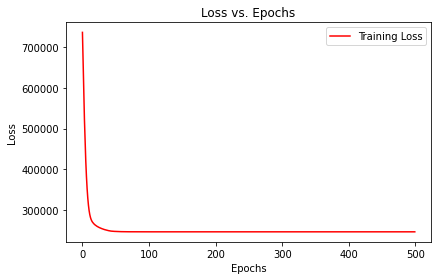

In [0]:
print("Validation loss is: ", vloss)

#The length is simply epochs
l = range(epochs)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Loss vs. Epochs")
plt.tight_layout()
plt.plot(l, tr_loss, label = "Training Loss", color = "red")
plt.legend()
plt.show()

In [0]:
from collections import Counter
print(Counter(clustering).keys())
print(Counter(clustering).values())

dict_keys([9, 3, 7, 6, 1, 5, 2, 18, 13, 14, 4, 11, 8])
dict_values([998, 1357, 953, 668, 1336, 231, 178, 248, 243, 248, 204, 1, 2])


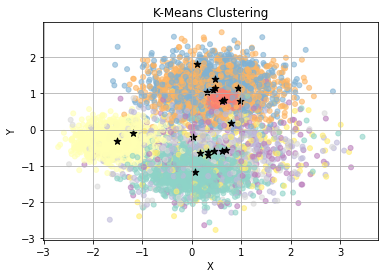

In [0]:
k = len(MU)
plt.scatter(data[:, 0], data[:, 1], c=clustering, 
            cmap=plt.get_cmap('Set3'), s=25, alpha=0.6)
plt.scatter(MU[:, 0], MU[:, 1], marker='*', c="black", 
            cmap=plt.get_cmap('Set1'), s=50, linewidths=1)
plt.title('K-Means Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

In [0]:
#gmm
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Loading data
data = np.load('data100D.npy')
#data = np.load('data2D.npy')
[num_pts, dim] = np.shape(data)

is_valid = 1
# For Validation set
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]


# Distance function for GMM
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)
    # TODO

    #same as distance func in kmeans
    xx = tf.expand_dims(X, 0)  # 1 x N x D
    mu = tf.expand_dims(MU, 1) # K x 1 x D
    rs = tf.reduce_sum(tf.square(xx - mu), axis=2)
    return tf.transpose(rs)

def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    # TODO
    """
    result = np.matmul(X, np.transpose(mu))
    for i in result.shape[0]:
      result[i, :] = (-1.0)*tf.reduce_sum((X[i, :] - mu)**2, axis=2) / 2 / np.transpose(sigma) - 0.5*np.log(2*np.pi*(sigma**2))
    return result
    """

    #again, vertorized version of the code above
    xx = distanceFunc(X,mu)
    #Note that if we don't squeeze, the division calculation would not be correct
    sigma = tf.squeeze(sigma)
    #Investigate: why must we include a rank here?
    return -0.5 * tf.to_float(tf.rank(X)) * tf.log(2 * np.pi * sigma) - xx / 2 / sigma

def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    # TODO

    log_pi = tf.squeeze(log_pi)
    return log_pi + log_PDF - reduce_logsumexp(log_pi + log_PDF,keep_dims=True)

K = 5
D = dim
N = len(data)
V = len(val_data)
X = data

x = tf.placeholder(tf.float32, [N, D])
mu = tf.Variable(tf.truncated_normal(shape = [K, D], stddev = 0.5, dtype = tf.float32))

epochs = 500
dummy_one = tf.Variable(tf.truncated_normal(shape = [K, 1], stddev = 0.5)) #Where exp(dummy1) = variance
sigma = tf.exp(dummy_one)
log_PDF = log_GaussPDF(x, mu, sigma)
dummy_two = tf.Variable(tf.truncated_normal(shape = [K, 1], stddev = 0.5)) #Where log_pi = logsoftmax(dummy2)
log_pi = tf.squeeze(logsoftmax(dummy_two)) #Note that logsumexp introduces an extra dimension

tr_cost   = (-1.0)*tf.reduce_sum(reduce_logsumexp(log_PDF + log_pi, keep_dims=True))
optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5)
optimizer = optimizer.minimize(tr_cost)

tr_loss = list()

#pred = tf.argmax(tf.nn.softmax(log_posterior(log_PDF, log_pi)), 1)
pred = tf.argmax(logsoftmax(log_posterior(log_PDF, log_pi)), 1)
with tf.Session() as sess:
  # initialize the variables
  init = tf.global_variables_initializer()
  sess.run(init)

  for i in range(epochs):
    feed_dict = {x: X}
    _, MU, t_loss = sess.run([optimizer, mu, tr_cost], feed_dict)
    tr_loss.append(t_loss)

  #This is to visualize the clusters
  clustering = sess.run(pred, feed_dict={x:X})

  #For reporting the best params
  s = sess.run(sigma, feed_dict={x:X})
  p = sess.run(log_pi, feed_dict={x:X})

  #For reporting validation loss
  vloss = sess.run((-1.0)*tf.reduce_sum(reduce_logsumexp(log_GaussPDF(v, MU, s) + p, keep_dims=True)), feed_dict={v:val_data})

sigma is:  [[12.066497  ]
 [50.184032  ]
 [ 0.75300246]
 [ 8.257126  ]
 [50.184616  ]]
log_pi is:  [-4.572774  -0.0185194 -8.439646  -8.183441  -4.8896127]
mu is:  [[ 4.49902385e-01  1.12370157e+00  8.93193245e-01 -6.71147346e-01
  -8.06197047e-01  1.41637313e+00  6.70453191e-01  1.16076982e+00
   5.99202096e-01  2.93919258e-02 -7.60759056e-01  9.46152747e-01
  -2.70865172e-01 -2.03437973e-02 -4.14866745e-01 -1.82330713e-01
   3.40374649e-01  4.09081697e-01  8.16523552e-01  4.07696128e-01
   2.87009686e-01  1.00959492e+00 -2.23150238e-01  3.15140843e-01
  -1.13716912e+00 -3.21298629e-01 -7.70229101e-02 -2.13427216e-01
  -5.51445223e-02 -7.82000363e-01  1.25262082e+00 -2.70415217e-01
  -1.15367365e+00 -9.48168933e-02 -6.02081358e-01 -7.54249096e-01
   1.17644703e+00  4.95700449e-01 -1.07398346e-01  3.47588748e-01
  -1.16453516e+00 -6.19405150e-01 -2.43891940e-01 -4.21788424e-01
  -1.08245182e+00  2.41868168e-01 -1.17332745e+00 -5.44159897e-02
  -8.59648824e-01  1.66359052e-01 -9.1997873

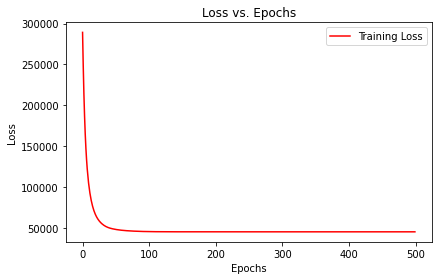

In [0]:
print("sigma is: ", s)
print("log_pi is: ", p)
print("mu is: ", MU)

print("Validation loss is:", vloss)

#The length is simply epochs
l = range(epochs)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title("Loss vs. Epochs")
plt.tight_layout()
plt.plot(l, tr_loss, label = "Training Loss", color = "red")
plt.legend()
plt.show()

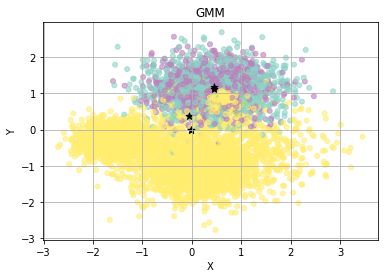

In [0]:
#clustering = sess.run(tf.argmin(distanceFunc(x, MU), axis=1), feed_dict={x:X})
#clustering = tf.argmin(distanceFunc(X, MU), axis=1)

k = len(MU)
plt.scatter(data[:, 0], data[:, 1], c=clustering, 
            cmap=plt.get_cmap('Set3'), s=25, alpha=0.6)
plt.scatter(MU[:, 0], MU[:, 1], marker='*', c="black", 
            cmap=plt.get_cmap('Set1'), s=50, linewidths=1)
plt.title('GMM')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()